In [111]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import imresize
import utils
%matplotlib inline

In [112]:
##### PART 1 - LOAD DATASET #########

# load images
images = utils.get_celeb_imgs()

# crop to square
images = [utils.imcrop_tosquare(img_i) for img_i in images]

# resize so every image is 100x100 - resulting shape will be (width,height,num channels)
images = [imresize(img,(100,100)) for img in images]

# resize to 4d array (width,height,depth,channels)
images = np.array(images).astype(np.float32)



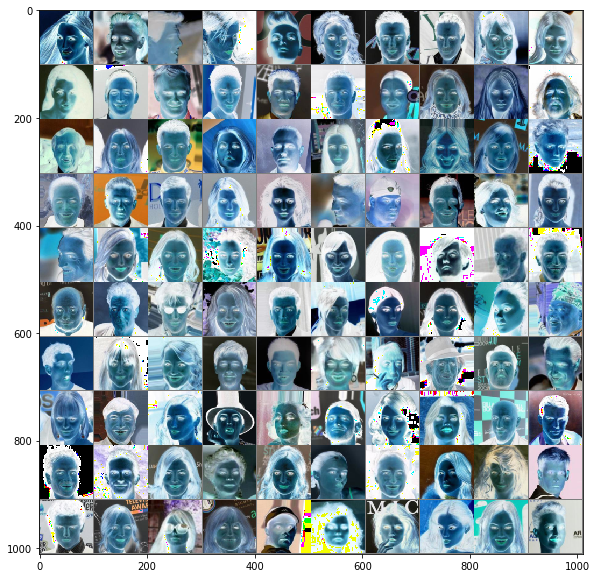

In [113]:
# plot dataset
plt.figure(figsize=(10,10))
plt.imshow(utils.montage(images,saveto='dataset.png'))

In [114]:
##### PART 2 - COMPUTE THE MEAN #########
sess = tf.InteractiveSession()

# compute mean of the image
mean_img_op = tf.reduce_mean(images,axis=0)

mean_img = sess.run(mean_img_op)

plt.figure(figsize=(10,10))
#plt.imshow(mean_img.astype(np.uint8))
plt.imsave(arr=mean_img.astype(np.uint8),fname='mean.png')

In [6]:
##### PART 3 - STANDARD DEVIATION #####
mean_img_4d = tf.reshape(mean_img,[1,100,100,3])
subtraction = images - mean_img_4d

# Now compute the standard deviation by calculating the
# square root of the expected squared differences
std_img_op = tf.sqrt(tf.reduce_mean(subtraction * subtraction, axis=0))

# Now calculate the standard deviation using your session
std_img = sess.run(std_img_op)

# Then plot the resulting standard deviation image:
# Make sure the std image is the right size!
assert(std_img.shape == (100, 100) or std_img.shape == (100, 100, 3))
plt.figure(figsize=(10, 10))
std_img_show = std_img / np.max(std_img)
#plt.imshow(std_img_show)
plt.imsave(arr=std_img_show, fname='std.png')

In [7]:
#### PART 4 - NORMALIZE DATASET ######
norm_imgs_op = tf.divide(tf.subtract(images,mean_img),std_img)
norm_imgs = sess.run(norm_imgs_op)

assert(norm_imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
#plt.imshow(utils.montage(norm_imgs.astype(np.uint8), 'normalized.png'))

norm_imgs_show = (norm_imgs - np.min(norm_imgs)) / (np.max(norm_imgs) - np.min(norm_imgs))
plt.figure(figsize=(10, 10))
#plt.imshow(utils.montage(norm_imgs_show, 'normalized.png'))

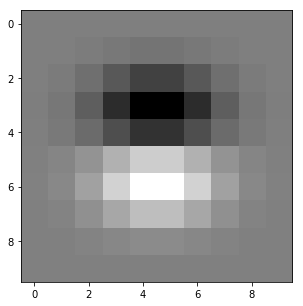

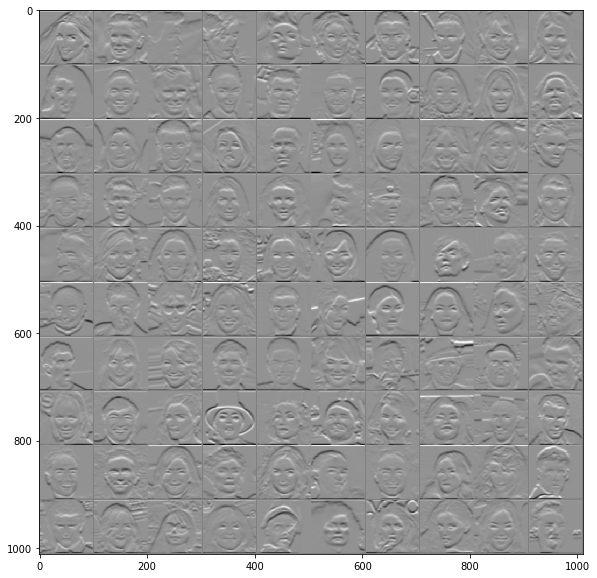

In [126]:

# first part - build gabor kernels for every image

x = tf.linspace(-3.0, 3.0, 100)

# The 1 dimensional gaussian takes two parameters, the mean value, and the standard deviation, which is commonly denoted by the name sigma.
mean = tf.placeholder(tf.float32,name="mean")
sigma = tf.placeholder(tf.float32,name="sigma")

# Don't worry about trying to learn or remember this formula.  I always have to refer to textbooks or check online for the exact formula.
z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                   (2.0 * tf.pow(sigma, 2.0)))) *
     (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))

z = z.eval(feed_dict={
    mean:0.0,
    sigma:0.5
})
ksize = 10
kernel = np.concatenate([utils.gabor(ksize)[:, :, np.newaxis] for i in range(3)], axis=2)

kernel_4d = tf.reshape(kernel, [ksize, ksize, 3, 1])
assert(kernel_4d.shape == (ksize, ksize, 3, 1))
kernel_4d = sess.run(kernel_4d)

# quick debug draw
plt.figure(figsize=(5, 5))
plt.imshow(kernel_4d[:, :, 0, 0], cmap='gray')
plt.imsave(arr=kernel_4d[:, :, 0, 0], fname='kernel.png', cmap='gray')

# next - convolve images against their kernals. 
convolved = utils.convolve(images,kernel_4d)
convolved_show = (convolved - np.min(convolved)) / (np.max(convolved) - np.min(convolved))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(convolved_show[..., 0], 'convolved.png'), cmap='gray')

In [104]:
#### PART 6 - SORT DATASET #####
flattened = convolved.ravel()

# not sure how 10,000 value was derrived
flattened = tf.reshape(flattened,[100,10000])
assert(flattened.get_shape().as_list() == [100, 10000])

values = tf.reduce_sum(flattened,axis=1)
idxs_op = tf.nn.top_k(values,k=100)[1]
idxs = sess.run(idxs_op)

sorted_imgs = np.array([images[idx_i] for idx_i in idxs])
plt.figure(figsize=(10, 10))
#plt.imshow(utils.montage(sorted_imgs, 'sorted.png'))